In [1]:
import matplotlib
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import string
import random
import nltk
from nltk.stem import WordNetLemmatizer

print(tf.__version__)

2.14.0


In [2]:
with open('intents_exercise.json', encoding='utf-8') as file:
    data = json.load(file)
    # print(data)

In [3]:
# Creating data X and data Y
words = []  
classes = []  
data_X = []
data_y = []

# Iterating over all the intents
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)  
        data_X.append(pattern) 
        data_y.append(intent["tag"])

        if intent["tag"] not in classes:
            classes.append(intent["tag"])

lemmatizer = WordNetLemmatizer()

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]


words = sorted(set(words))
classes = sorted(set(classes))

# Save the variables to a Python file
with open('variables.py', 'w') as f:
    f.write(f'words = {words}\n')
    f.write(f'classes = {classes}\n')
    f.write(f'data_X = {data_X}\n')

In [4]:
training = []
out_empty = [0] * len(classes)

# Creating the bag of words model
for idx, doc in enumerate(data_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Mark the index of class that the current pattern is associated to
    output_row = list(out_empty)
    output_row[classes.index(data_y[idx])] = 1

    # Add the one hot encoded BoW and associated classes to training
    training.append([bow, output_row])

# Shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)

# Split the features and target labels
train_X = np.array(list(training[:, 0]))
train_Y = np.array(list(training[:, 1]))


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Create the Neural Network Model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_X[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_Y[0]), activation="softmax"))

# Configure the optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(x=train_X, y=train_Y, epochs=500, validation_split=0.2, verbose=1)


Epoch 1/500
4/4 [==============================] - 3s 140ms/step - loss: 2.7843 - accuracy: 0.0485 - val_loss: 2.7726 - val_accuracy: 0.0000e+00
Epoch 2/500
4/4 [==============================] - 0s 23ms/step - loss: 2.7305 - accuracy: 0.1650 - val_loss: 2.8102 - val_accuracy: 0.0000e+00
Epoch 3/500
4/4 [==============================] - 0s 25ms/step - loss: 2.6162 - accuracy: 0.1553 - val_loss: 2.8409 - val_accuracy: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 2.5432 - accuracy: 0.1845 - val_loss: 2.8519 - val_accuracy: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 21ms/step - loss: 2.4612 - accuracy: 0.1553 - val_loss: 2.7851 - val_accuracy: 0.1538
Epoch 6/500
4/4 [==============================] - 0s 20ms/step - loss: 2.2520 - accuracy: 0.2427 - val_loss: 2.8445 - val_accuracy: 0.1154
Epoch 7/500
4/4 [==============================] - 0s 21ms/step - loss: 2.2720 - accuracy: 0.2136 - val_loss: 2.8119 - val_accuracy: 0.0769
Epo

In [6]:
model.save("chatbot_AI.h5")

c:\Users\knain\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last Epoch: Loss=0.5767905712127686, Acc=0.7961165308952332, Val Loss=2.643566131591797, Val Acc=0.5


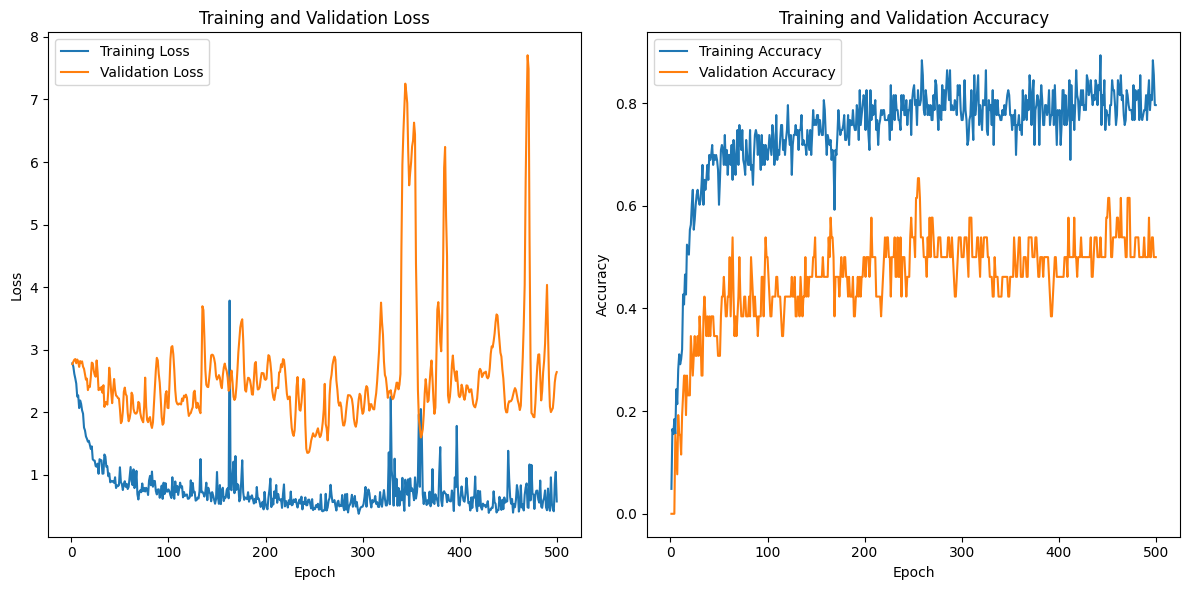

In [7]:
# Get the training and validation metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Print the last epoch's metrics
last_epoch = len(train_loss)
print(f"Last Epoch: Loss={train_loss[last_epoch-1]}, Acc={train_acc[last_epoch-1]}, Val Loss={val_loss[last_epoch-1]}, Val Acc={val_acc[last_epoch-1]}")

plt.figure(figsize=(12, 6))
# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [8]:
from tensorflow.keras.models import load_model

lemmatizer = WordNetLemmatizer()

model = load_model("./chatbot_AI.h5")


def clean_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def bag_of_words(text, vocab):
    tokens = clean_text(text)
    bow = [0] * len(vocab)
    for word in tokens:
        for idx, w in enumerate(vocab):
            if w == word:
                bow[idx] = 1
    return np.array(bow)

def pred_class(text, vocab, labels, model):
    bow = bag_of_words(text, vocab)
    result = model.predict(np.array([bow]))[0]
    thresh = 0.5
    y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
    y_pred.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in y_pred:
        return_list.append(labels[r[0]])
    return return_list

def get_response(intents_list, intents_json):
    if not intents_list:
        return "Sorry! I don't understand."
    else:
        tag = intents_list[0]
        list_of_intents = intents_json["intents"]
        for i in list_of_intents:
            if i["tag"] == tag:
                result = random.choice(i["responses"])
                break
        return result


In [9]:
import pyttsx3
import speech_recognition as sr
import re

r = sr.Recognizer()

def record_text():
    while True:
        try:
            with sr.Microphone() as source2:
                r.adjust_for_ambient_noise(source2, duration=1)
                print("Listening...")
                audio2 = r.listen(source2)
                print("Recognizing...")
                return r.recognize_google(audio2)
        except sr.RequestError as e:
            print("Could not request results; {0}".format(e))
        except sr.UnknownValueError:
            print("Unknown error occurred")

model = load_model("chatbot_AI.h5")

def get_response(intents_list, intents_json):
    if not intents_list:
        return "Sorry! I don't understand."
    else:
        tag = intents_list[0]
        list_of_intents = intents_json["intents"]
        for i in list_of_intents:
            if i["tag"] == tag:
                result = random.choice(i["responses"])
                break
        return result

while True:
    print("press 0 if you want to talk with the chatbot, or press any other key to exit")
    choice = input()
    if choice == "0":
        print("Chatbot activated")
        while True:
            inpText = record_text()
            print(inpText)
            if inpText.lower() == "0":
                print("Chatbot deactivated. Press 0 to activate again.")
                break
            intents = pred_class(inpText, words, classes, model)
            result = get_response(intents, data)
            print(result)
            engine = pyttsx3.init()
            engine.say(result)
            engine.runAndWait()
    else:
        break



press 0 if you want to talk with the chatbot, or press any other key to exit


In [ ]:
# print("Press 'e' if you don't want to chat with our ChatBot.")
# while True:
#     message = input("")
#     if message == 'e':
#         break
#     intents = pred_class(message, words, classes, model)
#     result = get_response(intents, data)
#     print(result)
